# Trump Tweets

Donald Trump, with all the controversy surrounding his identity, is currently the 45th President of the United States of America. He has attracted a greate deal of publicity from a lot of people around the world, including unpopular social groups.

His Twitter profile was mentioned several times during his presidential run by his opponents. With all the interest surrounding his Twitter profile, we set out to analyse some of those tweets.

We used data from the story [The World’s Favorite Donald Trump Tweets](https://fivethirtyeight.com/features/the-worlds-favorite-donald-trump-tweets/), published on **[fivethirtyeight.com](https://fivethirtyeight.com)**. The story provides some interesting insight into the personality of Donald Trump, however our focus will mostly lie in telling a story around the topics he tweeted about, and inferring his sentiments towards his opponents.

## Contents

* **[Preprocessing](#preprocessing)**
 *  [Text Corpus](#text-corpus)
* **[Transformation](#transformation)**
 *  [Document Dictionary](#document-dictionary)
 *  [tf-idf](#tf-idf)
  * [Step 1](#tf-idf-step-1)
  
* **[Preprocessing](#preprocessing)**
  * [Text Corpus and Formatting](#text-corpus)
* **[Transformation](#transformation)**
  * [Document Dictionary](#document-dictionary)
  * [tf-idf](#tf-idf)
    * [Step 1](#tf-idf-step-1)
    * [Step 2](#tf-idf-step-2)
    * [Step 3](#tf-idf-step-3)
* **[Modeling](#modeling)**
  * [Latent Semantic Indexing (LSI)](#latent-semantic-indexing)
    * [Topics](#lsi-topics)
  * [Similarity: LSI](#lsi-similarity)
  * [Latent Dirichlet Allocation (LDA)](#latent-dirichlet-allocation)
    * [Topics](#lda-topics)
  * [Similarity: LDA](#lda-similarity)
* **[Which topics were the most dominant?](#dominant-topics-percentage-contribution)**
* **[Most Representative Sentence for Each Topic](#most-representative-sentence-for-each-topic)**
* **[Frequency Distribution of Word Counts in Documents](#frequency-distribution-of-word-counts-in-documents)**
* **[Word Counts of Topic Keywords](#word-counts-of-topic-keywords)**
* **[What were the most discussed topics?](#most-discussed-topics-in-tweets)**
* **[Polarity & Subjectivity of Sentiments](#polarity-and-subjectivity)**
    * [Comparison: Polarity & Subjectivity](#comparison-polarity-and-subjectivity)
    * [Comparison: Times Series of Polarity & Subjectivity](#comparison-time-series-polarity-subjectivity)

In [75]:
# The usual suspects ...
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scripts.time_series as ts

# And their accomplices ...
from scipy import stats
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from collections import Counter
from pprint import pprint

# Settings
sns.set_style('white')
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [76]:
# Getting the data
df = pd.read_csv('../data/realDonaldTrump_poll_tweets.csv')

In [77]:
# Size
df.shape

(448, 3)

In [78]:
# Top rows
df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


<a id='preprocessing'></a>
## Preprocessing

In the preprocessing stage, we would like to clean our data before doing anything meaningful with it.

We will start of by formating the `created_at` column from being an `object` to a `datetime` object. We will want to use this format at the end when we carry out some simple time series.

In [79]:
# Datetime
ts.convert_to_datetime(data=df, column='created_at')

Now we focus our attention on the tougher part of preprocessing - cleaning the text. Twitter text tends to be unstructured and riddled with typos, wrong spellings, links etc. Often in the cleaning stage, it is quite possible to remove elements of the text that give it contextual meaning. We'll look at these and more in the next stage of preprocessing.

Right now, we will only focus on two things - `@`-mentions and external links. The mentions may contain some valuable information pointing towards some user, so we will only remove the `@` but retain everything else that follows it. Whilst with links, we would like to remove the `http` part and everything else that follows it (it's likely going to be a shortening of the full link which will be a random string without any useful information to us).

In [80]:
# Removing @user references and links
def strip_links(text):
    '''Removes links in text.'''
    link_regex = re.compile(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def strip_all_entities(text):
    '''Removes @user references and hashtags.'''
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, ' ')
    words = list()
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [81]:
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0         It s just a 2 point race Clinton 38 Trump 36
1    Poll Donald Trump Sees 17 Point Positive Swing...
2                             Great new poll thank you
3    Great POLL numbers are coming out all over Peo...
4    Another new poll Thank you for your support Jo...
5                     Great new poll thank you America
6    Despite spending 500k a day on TV ads alone fa...
7                         Great poll Florida Thank you
8                                   New poll thank you
9    New Q poll out we are going to win the whole d...
Name: text, dtype: object

<a id='text-corpus'></a>
### Text Corpus and Formatting

Having removed the links and the random strings associated with the external links, we will notice that our text still has several issues we have to deal with before modeling.

For our us to successfully model our data and get good results, we will want to remove the certain elements of text that may lead our analysis astray. For example, if we built our model and wanted to know which words were the most common, we likely will find that words like `a`, `it`, `the` etc., would occur frequently.

We use these words quite a lot when we communicate with other humans. They help us connect our nouns and verbs providing form and structure to what we are talking about. However, in sentiment analysis this can sometimes be a bad thing. We are interested in understanding the structure of the text, we will want to neglect these words since they do not provide any vital information about the structure serving only to enhance form which is quite subjective.

So, we will proceed to remove these connectors and other punctuation marks from the text. There is a handy package from `nltk` that contains most of the key words found in the English language, so we do not need to manually list them.

However, we need to be careful. Twitter text sometimes contains unnecessary punctuation marks either as byte emoticons, as well as platform specific words or abbreviations (e.g., `rt` for `retweet`) which do not provide much value in understanding the structure of the text. We will want to remove these in addition to the emoticons and emojis that have somewhat become a 'language' of sorts themselves.

To identify emojis in the tweets, we will use their unicode encodings and map them to their pictorial symbols. We will also include the `iOS` encodings since Apple devices have extra encodings which are not found in other devices.

The end goal of preprocessing is to end up with a collection of all the word representation in the tweets, or the corpus. It will be the primary instrument we will use to transform the tweet into a numerical form by *tokenizing* the words. Because this process relies on specifying a word delimiter, or a placeholder that seperates words, we will have to be cautious of unnecessary empty space and will remove all excess spaces.

In [82]:
# Text corpus
def create_document_corpus(df, column):
    '''Creates document corpus.'''
    return [i for i in df[column]]

# Removing common words and tokenize
def remove_common_words_and_tokenize(document_corpus):
    '''Removes common words and tokenizes text.'''
    stop_words = set(stopwords.words('english'))
    stop_words.update(['-', '=', '+', '*','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']',
                       '{', '}', 'amp', 'kkk', 'hahaha', 'haha', 'ha', 'RT', 'i’m', '…', '–', 'http'])
    stop_words.update([i for i in string.ascii_lowercase]) # Including lowercase letters
    stop_words.update([i for i in string.ascii_uppercase]) # Including uppercase letters
    for doc in document_corpus:
        list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
    stop_words.update(list_of_words)

    # Removing common words
    return [[word for word in doc.lower().split() if word not in stop_words] for doc in document_corpus]

# Removing words that appear only once
def remove_words_appearing_only_once(text_corpus):
    '''Removes words that appear only once.'''
    frequency = defaultdict(int)
    for text in text_corpus:
        for token in text:
            frequency[token] += 1

    return [[token for token in text if frequency[token] > 1] for text in text_corpus]

# Removing emojis
def remove_emojis(text_corpus):
    '''Removes emojis and emoticons from text corpus.'''
    # Emoticons and emojis
    # HappyEmoticons
    emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                           ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                           '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                           'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
                           '<3'])

    # Sad Emoticons
    emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                         ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                         ':c', ':{', '>:\\', ';('])

    # Emoji patterns
    emoji_pattern = re.compile("["
             u"\U0001F600-\U0001F64F"  # emoticons
             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
             u"\U0001F680-\U0001F6FF"  # transport & map symbols
             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
             u"\U00002702-\U000027B0"
             u"\U000024C2-\U0001F251"
             "]+", flags=re.UNICODE)

    # Combine
    emoticons = emoticons_happy.union(emoticons_sad)
    return [[token for token in text if token not in emoticons] for text in text_corpus]

# Removing empty tokens
def remove_empty_corpus_tokens(text_corpus):
    '''Removes empty text corpus tokens.'''
    return [text for text in text_corpus if len(text) > 1]

In [9]:
# Formatting
document = create_document_corpus(df, 'text')
text_corpus = remove_common_words_and_tokenize(document)
refined_text_corpus = remove_words_appearing_only_once(text_corpus)
no_emojis_refined_text_corpus = remove_emojis(refined_text_corpus)
no_empty_tokens_refined_text_corpus = remove_empty_corpus_tokens(no_emojis_refined_text_corpus)

# Printing the top 10
pprint(no_empty_tokens_refined_text_corpus[:10])

[['2', 'point', 'race', 'clinton', '38', 'trump', '36'],
 ['poll', 'donald', 'trump', '17', 'point', 'two', 'breitbart', 'great'],
 ['great', 'new', 'poll', 'thank'],
 ['great',
  'poll',
  'numbers',
  'coming',
  'people',
  'want',
  'another',
  'four',
  'years',
  'obama',
  'crooked',
  'hillary',
  'even',
  'worse'],
 ['another', 'new', 'poll', 'thank', 'support'],
 ['great', 'new', 'poll', 'thank', 'america'],
 ['despite', 'spending', 'day', 'ads', 'nationwide', 'zero', 'sad'],
 ['great', 'poll', 'florida', 'thank'],
 ['new', 'poll', 'thank'],
 ['new', 'poll', 'going', 'win', 'make', 'america', 'great']]


Taking a look at a small sample of the corpus of tweets, we'll note that there are no longer any `@` references, no links or random strings, no keywords, no unnecessary punctuation marks, and no emoticons or emojis. The text is now in a fairly workable state and we can proceed with modeling.

<a id='transformation'></a>
## Transformation

<a id='document-dictionary'></a>
### Document dictionary

Having tokenised the text by identifying each of the words seperated by a white space, we now focus our attention on creating a dictionary of all the words used in the tweets before building our models.

The dictionary will contain a representation of all the words in the corpus - each word will be represented once. Once we've done that, we are then in a position to assign a number to each word. This can be either
>- positional, where we assign a number to each word based on its location in the tweet and subsequently in the corpus; or
>- count based, where we count the number of times the word appears, storing that number in the dictionary before using it to describe the word using its frequency.

In our case, we will opt for to use both. The positional IDs of each of the words will help us to determine the location of the word based on it's frequency. We'll then transform the text into a numerical representation.

In `gensim`, the `corpora.Dictionary` method accomplishes this by determining the frequency of each word, normalizing the frequencies then connecting the normalised values to the word IDs. From this, we will then be able to construct a vector of the numerical identities of the words effectively turning the text corpus into a consice and compact numerical representation.

In [10]:
# Create dictionary of document
bag = corpora.Dictionary(no_empty_tokens_refined_text_corpus)
bag.save('../models/trump.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in no_empty_tokens_refined_text_corpus]
corpora.MmCorpus.serialize('../models/trump.mm', corpus)

We have assigned a unique integer ID to all words appearing in the corpus by:
   
   1. sweeping across the texts
   2. collecting word counts (frequency) and relevant statistics

***

<a id='tf-idf'></a>
### _tf-idf_

What we now want to do is construct an instrument that allows us to differentiate (or more accurately, characterise) one word from another by taking into consideration how each tweet differs from another. This is called ___term frequency-independent document frequency (tf-idf)___. We'll create it in three steps:

<a id='tf-idf-step-1'></a>
#### Step 1:

We have initialize (or simply, train) a model that will begin the transformation process. Different transformations may require different initialization parameters; however, in our case, ___tf-idf___, the "training" consists simply of going through the supplied corpus once and computing document frequencies of all its features.

**A note on transaformations** (from the `gensim` site):
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where ___tf-idf___ vectors are expceted, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

<a id='tf-idf-step-2'></a>
#### Step 2:
After creating our ___tf-idf___, we are now able to convert any vector from the old representation (___bag-of-words___ integer counts) to the new representation (___tf-idf___ real-valued weights) by simply reading its values.

At this point, our corpus (the numerical representation of our text data) is a weighted vector because it takes into consideration each word's frequency relative to all the documents in which it appears. We can do this for any vector (provided they come from the same vector space), even if they are not used in the corpus at all. This can be achived by _folding-in_ for ___LSA___ and by _topic inference_ for ___LDA___ (`gensim` site).

<a id='tf-idf-step-3'></a>
#### Step 3:
We will transform our ___tf-idf___ corpus via [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing) into a latent $n$-dimension space. Here $n$ is translated to be the number of topics that we suspect inherently exist in the corpus.

In [11]:
# Initializing tf-idf
def create_tfidf_model(corpus):
    '''Transform text to tf-idf model.'''
    # Initialization
    tfidf = models.TfidfModel(corpus)
    # Applying the transformation to the whole corpus
    return tfidf, tfidf[corpus]

tfidf, corpus_tfidf = create_tfidf_model(corpus)

<a id='modeling'></a>
## Modeling

<a id='latent-semantic-indexing-and-latent-dirichlet-allocation'></a>
### Latent Semantic Indexing (LSI) & Latent Dirichlet Allocation (LDA)

Now we map our ___tf-idf___ through ___LSI___ into an $n$-dimensional space. Remember that Twitter supports 140 characters (I think that has changed now to much more than 140) and the average word is 9 characters long, which means our tweet corpus has about 15 dimensions.

In [12]:
# Initializing an LSI transformation
def create_lsi_model(corpus_tfidf, num_topics, id2word=bag):
    '''Initializes an LSI transformation of tf-idf model.'''
    lsi = models.LsiModel(corpus_tfidf, id2word=bag, num_topics=num_topics)
    # Model persistence: save(), load()
    lsi.save('../models/trump.lsi')
    lsi = models.LsiModel.load('../models/trump.lsi')
    return lsi, lsi[corpus_tfidf]

# Initialize an LDA transformation
def create_lda_model(corpus_tfidf, num_topics, idf2word=bag):
    '''Initializes LDA transformation.'''
    # LDA Transformation
    lda = models.LdaModel(corpus_tfidf, id2word=bag, num_topics=num_topics)
    return lda, lda[corpus_tfidf]

In [13]:
lsi, corpus_lsi = create_lsi_model(corpus_tfidf, num_topics=5)
lsi.print_topics()

[(0,
  '-0.547*"thank" + -0.413*"new" + -0.385*"great" + -0.202*"poll" + -0.165*"america" + -0.150*"numbers" + -0.144*"iowa" + -0.119*"reuters" + -0.118*"trump" + -0.109*"big"'),
 (1,
  '-0.457*"thank" + 0.311*"trump" + 0.187*"lead" + 0.187*"donald" + 0.184*"carson" + 0.176*"rubio" + -0.175*"great" + 0.169*"cruz" + 0.166*"leads" + 0.163*"6"'),
 (2,
  '0.275*"debate" + -0.220*"6" + -0.214*"carson" + -0.190*"thank" + 0.187*"big" + -0.180*"rubio" + 0.178*"america" + 0.177*"great" + 0.177*"every" + 0.174*"numbers"'),
 (3,
  '-0.416*"great" + 0.379*"debate" + -0.282*"big" + -0.264*"leads" + 0.194*"thank" + 0.187*"said" + 0.186*"iowa" + 0.178*"national" + 0.162*"post" + 0.154*"lead"'),
 (4,
  '0.362*"debate" + -0.334*"national" + -0.314*"iowa" + -0.201*"new" + 0.183*"said" + 0.167*"great" + 0.166*"carson" + -0.161*"lead" + 0.149*"thank" + 0.145*"rubio"')]

<a id='lsi-topics'></a>
#### Topics

According to ___LSI___, we have the following topics (they are not arranged in any particular order - rerunning the notebook will likely change the order they are printed):
>
>**Topic 1** - poll numbers, Iowa, Reuters and Trump.
>
>**Topic 2** - Trump, Carson, Rubio, and Cruz. This may Trump making comparisons with his competition.
>
>**Topic 3** - debate (probably the Presidential Debate), Carson, and Rubio hinting at what these individuals may have said in the debate.
>
>**Topic 4** - great, debate, big, and leads. This may be Trump talking about the debate and the favorable outcome.
>
>**Topic 5** - similar words as topic 4.

Since one of the topics contains the same words as another pre-existing topic, we now know that there are four topics of discussed in the tweets.

In [14]:
lsi, corpus_lsi = create_lsi_model(corpus_tfidf, num_topics=4)
lsi.print_topics()

[(0,
  '0.546*"thank" + 0.413*"new" + 0.385*"great" + 0.202*"poll" + 0.165*"america" + 0.150*"numbers" + 0.144*"iowa" + 0.120*"reuters" + 0.118*"trump" + 0.109*"big"'),
 (1,
  '0.457*"thank" + -0.311*"trump" + -0.186*"donald" + -0.186*"lead" + -0.185*"carson" + -0.177*"rubio" + 0.176*"great" + -0.168*"cruz" + -0.167*"leads" + -0.162*"6"'),
 (2,
  '0.279*"debate" + -0.215*"carson" + -0.214*"6" + -0.187*"thank" + 0.187*"big" + 0.180*"every" + -0.179*"rubio" + 0.179*"great" + 0.175*"america" + 0.174*"numbers"'),
 (3,
  '0.415*"great" + -0.376*"debate" + 0.282*"big" + 0.263*"leads" + -0.192*"thank" + -0.187*"iowa" + -0.185*"national" + -0.180*"said" + -0.166*"post" + -0.160*"lead"')]

__So, what do we know so far?__

We know that when Trump was tweeting, he used the phrase "Thank you" a lot when he was talking about how he was leading in the presidential polls in comparison to his opponents, possibly after the Presidential Debate. His slogan, "Let's make America great again!", appears to have been reiterated multiple times.

Effectively, Donald Trump seems to have tweeted his slogan and leading in the polls.

***
<a id='lsi-similarity'></a>
### Similarity

Now we want to take a look at what Trump said (specifically) to his opposition. We can find that out by querying  the text corpus.

To do that, we simply reverse what we have been doing all along:

>- transform the corpus into the ___LSI___ space
>- look for the word we are interested in from the ___LSI___ space
>- then map the result onto the numerical corpus
>- print the result by referencing the text corpus

In [48]:
def query_similarity(doc, num_tweets, model, dict_of_doc=bag, doc_corpus=document):
    # Initializing the query structure: transform corpus to LSI space and index it
    index = similarities.MatrixSimilarity(model[corpus])

    # Index persistence
    index.save('../models/trump.index')
    index = similarities.MatrixSimilarity.load('../models/trump.index')
    
    # Performing queries
    vec_bow = dict_of_doc.doc2bow(doc.lower().split())

    # Convert the query to LSI space
    vec = model[vec_bow]

    # Perform a similarity query against the corpus
    sims = index[vec]

    # Ranking the tweets by their weights of similarity
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    # Printing the associated Tweets:
    for i in range(num_tweets):
        print("Tweet Rank #{}:\tWeight: {}\nRaw text: {}\n".format(i+1, sims[i][1], doc_corpus[sims[i][0]]))

In [50]:
query_similarity(doc='Hillary Clinton', num_tweets=5, model=lsi)

Tweet Rank #1:	Weight: 0.9983930587768555
Raw text: Nevada Poll Donald Trump 33 Ted Cruz 20 Marco Rubio 11 via Great news

Tweet Rank #2:	Weight: 0.9973537921905518
Raw text: New Poll Shows Donald Trump Blowing Everyone Else Out of the Water

Tweet Rank #3:	Weight: 0.9967166185379028
Raw text: Key State Florida Poll Trump 32 Beats Combined

Tweet Rank #4:	Weight: 0.9957194924354553
Raw text: CNBC poll Trump won

Tweet Rank #5:	Weight: 0.9924280047416687
Raw text: As soon as John Kasich is hit with negative ads he will drop like a rock in the polls against Crooked Hillary Clinton I will win



In [52]:
query_similarity(doc='Hillary Clinton', num_tweets=5, model=lda)

Tweet Rank #1:	Weight: 0.9999884963035583
Raw text: Heading now for Reno Nevada for a big rally Good poll numberd all over

Tweet Rank #2:	Weight: 0.9999808073043823
Raw text: I am in first place by a lot in all polls tied for first place with Ben Carson in one Iowa poll I thought you knew this thanks

Tweet Rank #3:	Weight: 0.9999367594718933
Raw text: Donald Trump Leads by 9 Points in Pew Poll – Jeb Bush in Free Fall

Tweet Rank #4:	Weight: 0.9989625215530396
Raw text: RT Joe Poll at the top

Tweet Rank #5:	Weight: 0.9983057379722595
Raw text: has spent 63 000 000 and is at the bottom of the polls I have spent almost nothing and am at the top WIN



When we make a query for "Hillary Clinton", the leading tweet (by weight) made by the `realDonaldTrump` references poll results - something may not be right here. The first explicit mention of Hillary's full name is on the fourth tweet. By retrieving the top 10 tweets referencing Hillary, we find her explicitly mentioned twice. These results seem suspicious, but let's try another term.

After running several more queries, we don't seem to be getting the expected results. Essentially, our model should be able to retrieve the specific tweets with the greatest weight associated with our word(s) or interest. But it seems to be returning inconsistent results.

When we use the ___LDA___ model we get worse results - none of the tweets returned make any explicit reference to the word of interest! Why is that the case?

One explanation could be the quality of the input data we are using - it may not be sufficiently heterogenous. Our models may be failing to determine underlying structure in the text because there may be none. The tweets were using were extracted during the Presidential race, so there may not be much else that the `realDonalTrump` could have been tweeting about.

<a id='dominant-topics-percentage-contribution'></a>
## Which topics were the most dominant?

Now we want to know which of the four topics we determined were the most dominant. We are taking a more pronounced look at the area which `realDonaldTrump` focused on talking about the most on Twitter during the Presidential race.

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=no_empty_tokens_refined_text_corpus):
    '''Returns dominant topics and respective percentage contributions with original text.'''
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_distribution', 'topic_keywords']
    
    # Add original text to the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

Text(0.5, 1.0, 'Distribution of Topic Dominance')

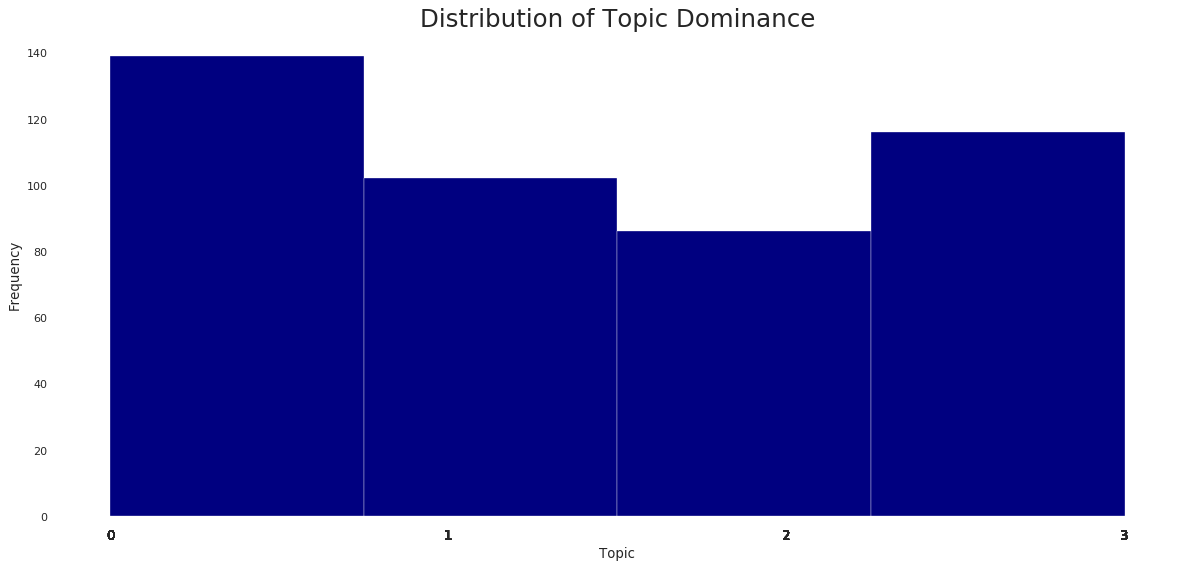

In [56]:
# Formatting
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda,
                                                 corpus=corpus,
                                                 texts=no_empty_tokens_refined_text_corpus)
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number',
                             'dominant_topic',
                             'topic_percentage_contribution',
                             'keywords',
                             'text']
df_dominant_topic.head(10)

# Plotting
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(df_dominant_topic.dominant_topic, bins=4, color='navy')
plt.xticks(sorted(df_dominant_topic.dominant_topic), size=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.title('Distribution of Topic Dominance', fontsize=22)

<a id='most-representative-sentence-for-each-topic'></a>
## Most representative sentence for each topic

In [55]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9590,"thank, new, great, poll, numbers, iowa, cruz, ...","[boston, herald, franklin, pierce, poll, trump..."
1,1.0,0.9639,"trump, national, poll, new, debate, far, 6, le...","[michigan, poll, 2, 24, 2016, trump, 35, 5, ru..."
2,2.0,0.9539,"great, leads, big, trump, poll, leading, flori...","[every, poll, time, drudge, slate, others, sai..."
3,3.0,0.9599,"new, great, thank, trump, lead, poll, donald, ...","[thank, illinois, great, news, 3, 15, trump, 2..."


Text(0.5, 1.0, 'Distribution of Sentence Percentage Contribution')

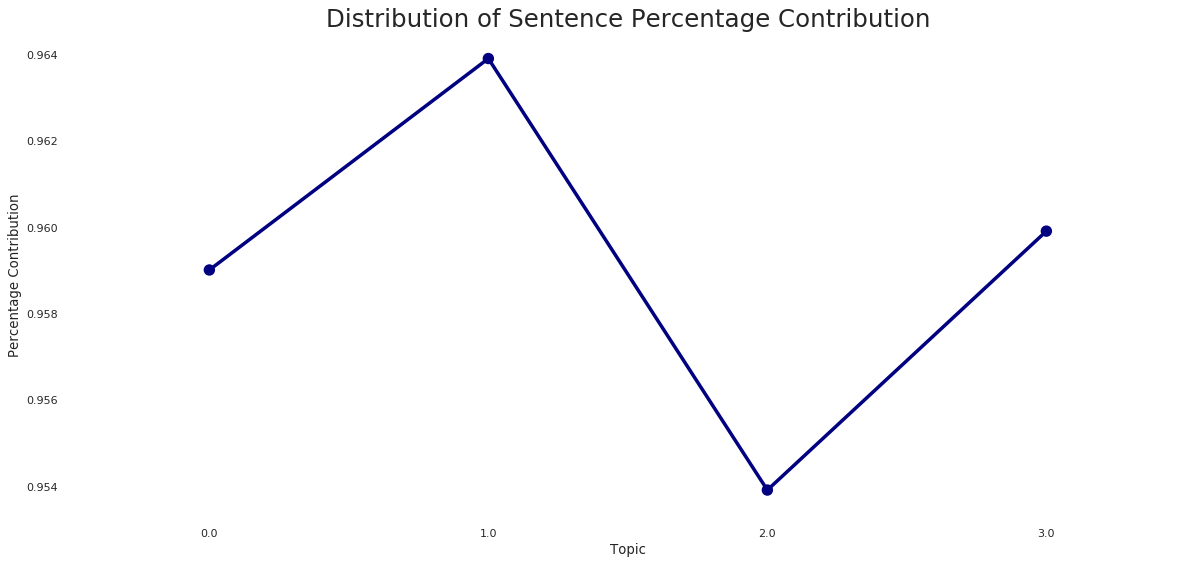

In [65]:
plt.figure(figsize=(18, 8), dpi=80)
sns.categorical.pointplot(sent_topic_sorted_df_mallet.topic_number,
                          sent_topic_sorted_df_mallet.topic_percentage_contribution,
                          color='navy')
plt.ylabel('Percentage Contribution', fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.title('Distribution of Sentence Percentage Contribution', fontsize=22)

<a id='frequency-distribution-of-word-counts-in-documents'></a>
## Frequency distribution of word counts in documents

Text(0.5, 1.0, 'Distribution of Document Word Counts')

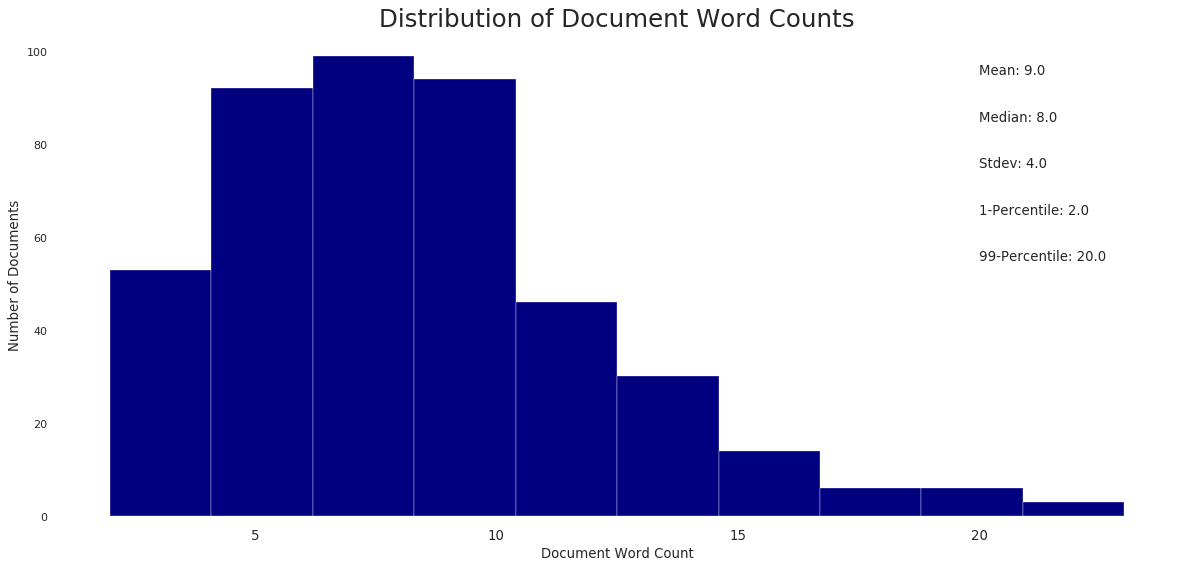

In [66]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(doc_length, bins=10, color='navy')
plt.text(20, 95, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=12)
plt.text(20, 85, 'Median: ' + str(round(np.median(doc_length))), fontsize=12)
plt.text(20, 75, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=12)
plt.text(20, 65, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=12)
plt.text(20, 55, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=12)
plt.xticks(size=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Document Word Count', fontsize=12)
plt.title('Distribution of Document Word Counts', fontsize=22)

<a id='word-counts-of-topic-keywords'></a>
## Word counts of topic keywords

In [30]:
# Formatting
def word_counts_of_topic_keywords(lda_model, text_corpus):
    '''Returns the word counts of topic keywords.'''
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in text_corpus for w in w_list]
    counter = Counter(data_flat)
    
    out = list()
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, counter[word]])
    return pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

data = word_counts_of_topic_keywords(lda, no_empty_tokens_refined_text_corpus)

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

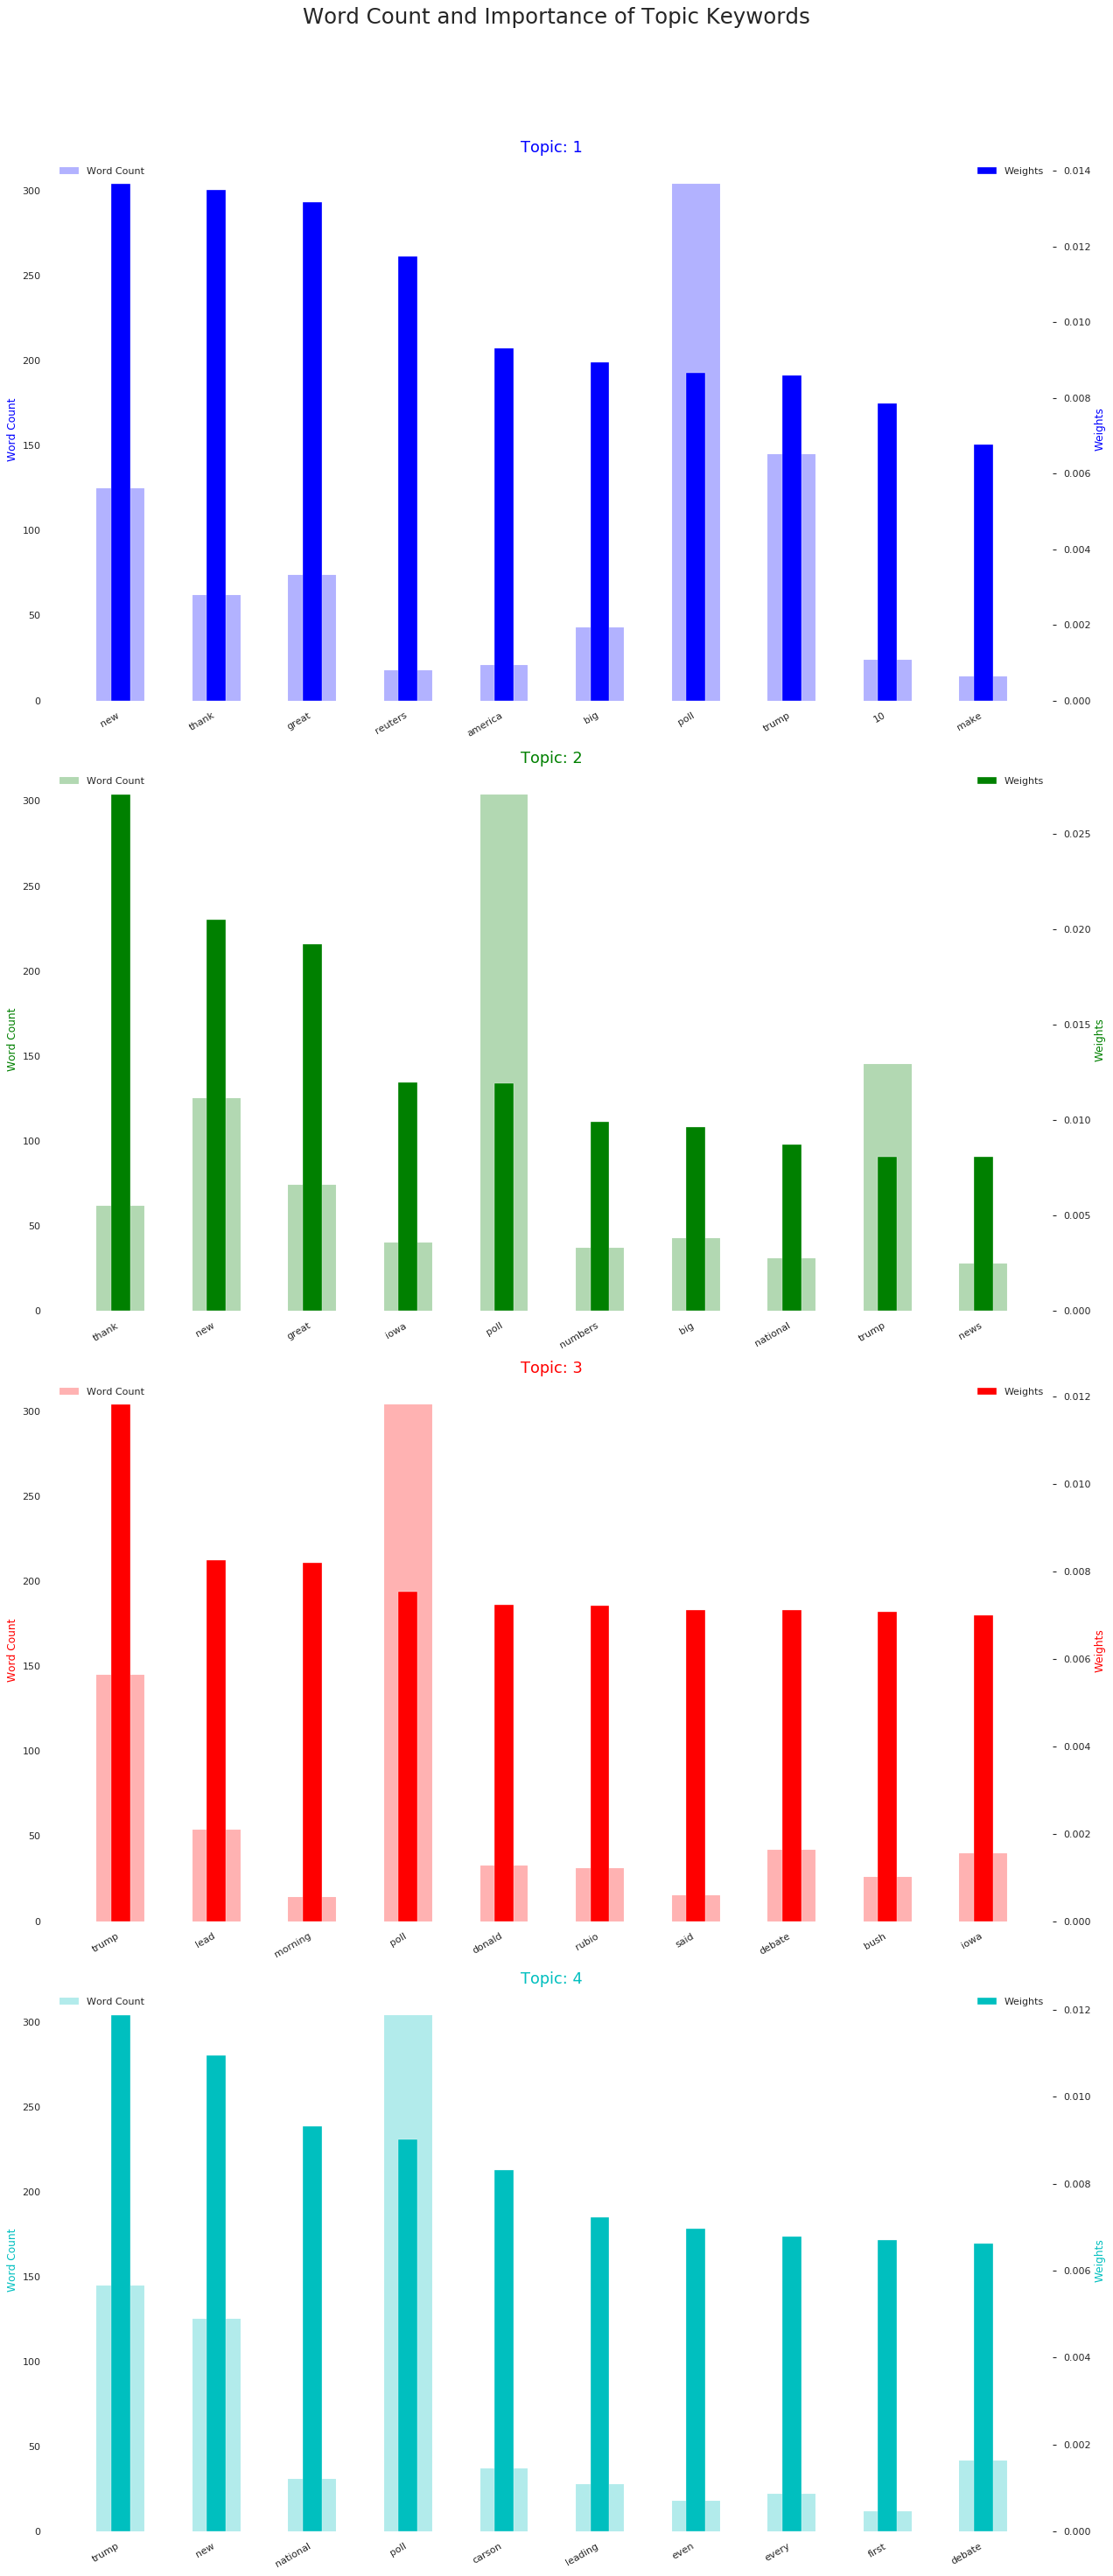

In [31]:
# Plotting
fig, axes = plt.subplots(4, 1, figsize=(16, 35), sharey=True, dpi=80)
cols = [color for name, color in mcolors.BASE_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

<a id='most-discussed-topics-in-tweets'></a>
## What are the most discussed topics?

We will create two plots:

>1. the number of documents for each topic by assigning the document to the topic that has the most weight in that document.
>2. the number of documents for each topic by summing up the actual weight contribution of each topic to respective documents.

In [68]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics, topic_percentages = list(), list()
    for i, corp in enumerate(corpus_sel):
        topic_id_percentages = lda[corp]
        dominant_topic = sorted(topic_id_percentages, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_id_percentages)
    return dominant_topics, topic_percentages

In [69]:
# Formatting
dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

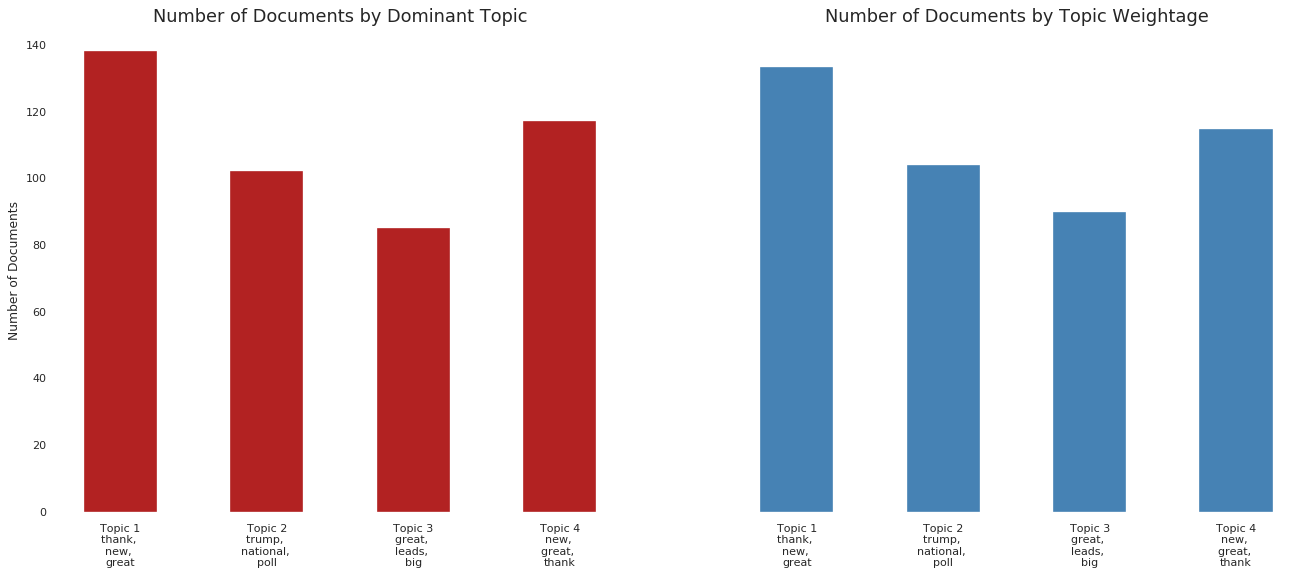

In [70]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic',
        height='count',
        data=df_dominant_topic_in_each_document,
        width=.5,
        color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + 
                               df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

<a id='polarity-and-subjectivity'></a>
## Polarity and subjectivity of sentiments

In [71]:
# Clean text
def append_cleaned_text(texts, df, column_name):
    '''Added cleaned text column to dataframe.'''
    cleaned_text = list()
    for i in range(len(texts)):
        if len(texts[i]) != 0:
            cleaned_text.append(' '.join(i for i in texts[i]))
        else:
            cleaned_text.append(' ')
    df[column_name] = cleaned_text

# Create polarity and subjectivity columns
def polarity_and_subjectivity(df, column):
    '''Creates the polarity and subjectivity columns.'''
    polarity = list(map(lambda tweet: TextBlob(tweet).polarity, df[column]))
    subjectivity = list(map(lambda tweet: TextBlob(tweet).subjectivity, df[column]))
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity

In [72]:
# Formatting
append_cleaned_text(no_emojis_refined_text_corpus, df, 'cleaned_text')
polarity_and_subjectivity(df=df, column='cleaned_text')

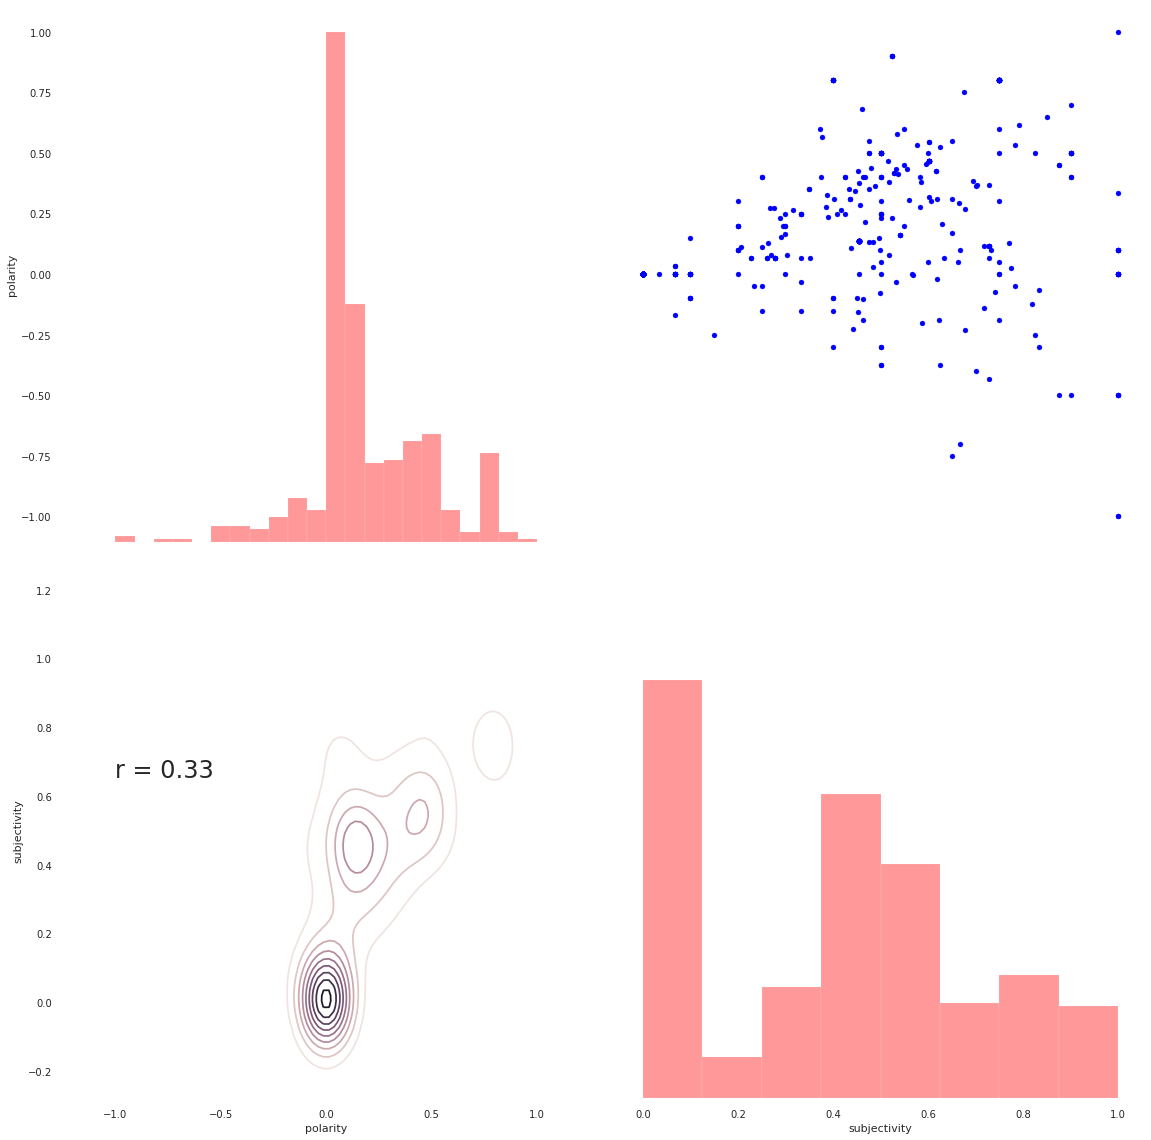

In [73]:
# Correlations
def correlations(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6),
                xycoords=ax.transAxes,
                size=24)

cmap = sns.cubehelix_palette(light=1, dark=.01, hue=.5, as_cmap=True)
sns.set_context(font_scale=2)

# Pairgrid setup
g = sns.PairGrid(df.drop('id', axis=1), height=8)
# Scatterplot on upper triangle
g.map_upper(plt.scatter, s=25, color='blue')
# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color='red')
# Densityplot and correlation coefficients on lower triangle
g.map_lower(sns.kdeplot, cmap=cmap)
g.map_lower(correlations)

(None, None)

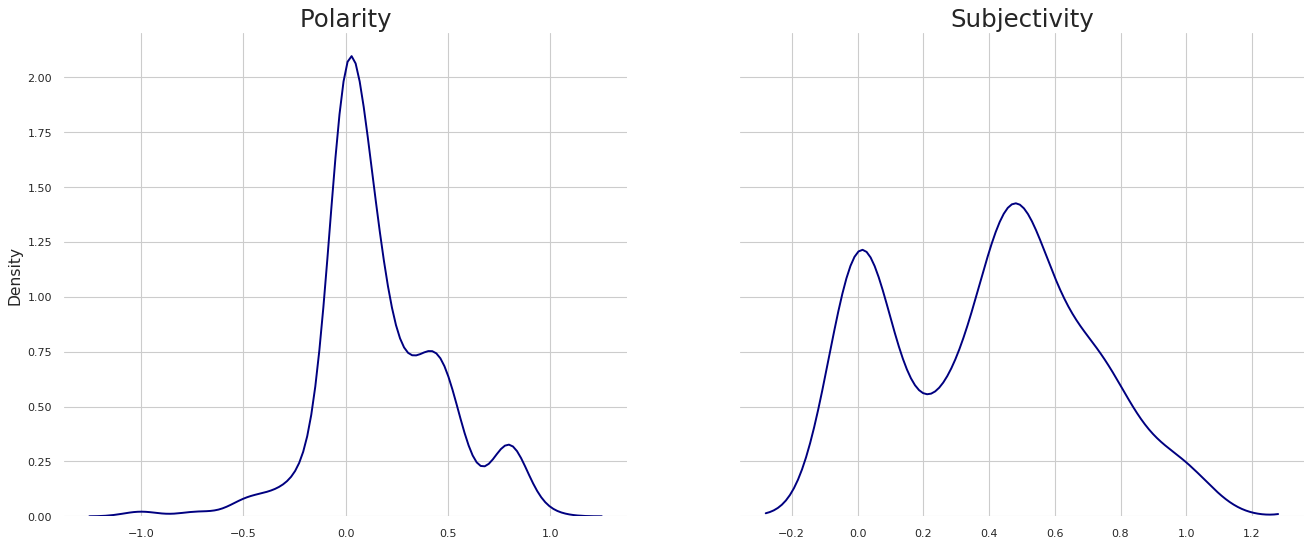

In [74]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(df['polarity'], ax=ax1, color='navy', hist=False)
sns.distplot(df['subjectivity'], ax=ax2, color='navy', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

<a id='comparison-polarity-and-subjectivity'></a>
### Comparison: Polarity and subjectivity

(None, None)

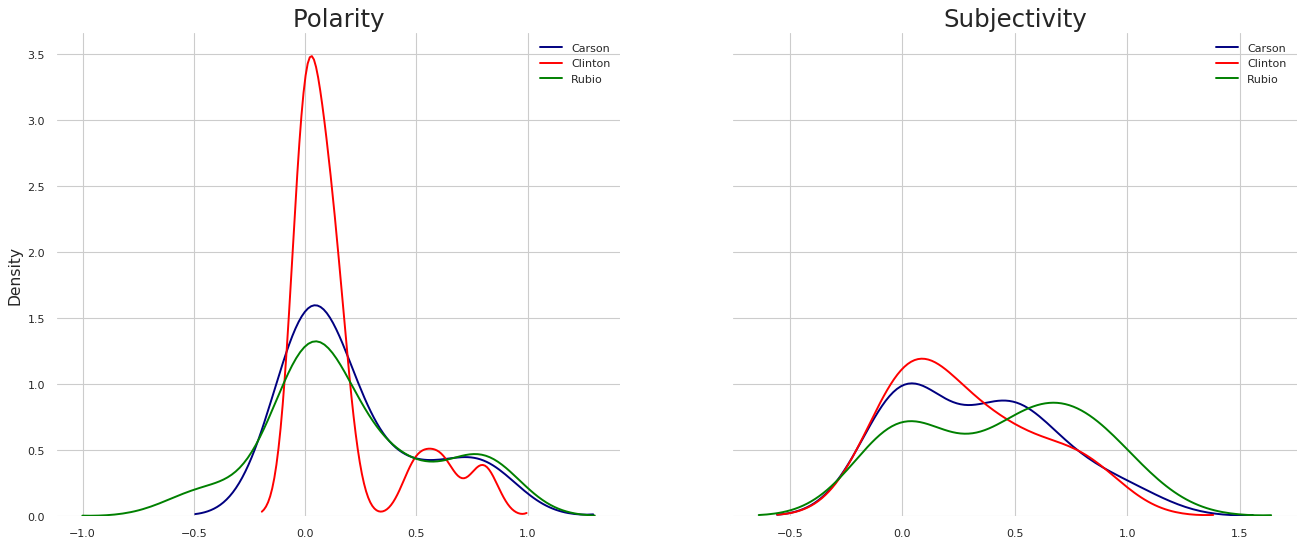

In [41]:
# Comparing subjectivity and polarity between candidates
carson = df.loc[df['text'].str.contains('Carson')]
clinton = df.loc[df['text'].str.contains('Clinton')]
rubio = df.loc[df['text'].str.contains('Rubio')]

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(carson['polarity'], label='Carson', ax=ax1, color='navy', hist=False)
sns.distplot(clinton['polarity'], label='Clinton', ax=ax1, color='red', hist=False)
sns.distplot(rubio['polarity'], label='Rubio', ax=ax1, color='green', hist=False)
sns.distplot(carson['subjectivity'], label='Carson', ax=ax2, color='navy', hist=False)
sns.distplot(clinton['subjectivity'], label='Clinton', ax=ax2, color='red', hist=False)
sns.distplot(rubio['subjectivity'], label='Rubio', ax=ax2, color='green', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

<a id='comparison-time-series-polarity-subjectivity'></a>
### Comparison: Time series of polarity and subjectivity

In [42]:
# Creating time series objects
# Polarity
carson_polarity = ts.create_series(carson, 'created_at', 'polarity')
clinton_polarity = ts.create_series(clinton, 'created_at', 'polarity')
rubio_polarity = ts.create_series(rubio, 'created_at', 'polarity')

# Subjectivity
carson_subjectivity = ts.create_series(carson, 'created_at', 'subjectivity')
clinton_subjectivity = ts.create_series(clinton, 'created_at', 'subjectivity')
rubio_subjectivity = ts.create_series(rubio, 'created_at', 'subjectivity')

In [43]:
def smooth(x,window_len=11,window='hanning'):
    '''smooth the data using a window with requested size.
    
    NB: Taken from scipy cookbook.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)]
          instead of just y.
    '''

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    return np.convolve(w/w.sum(), s, mode='valid')

(None, None)

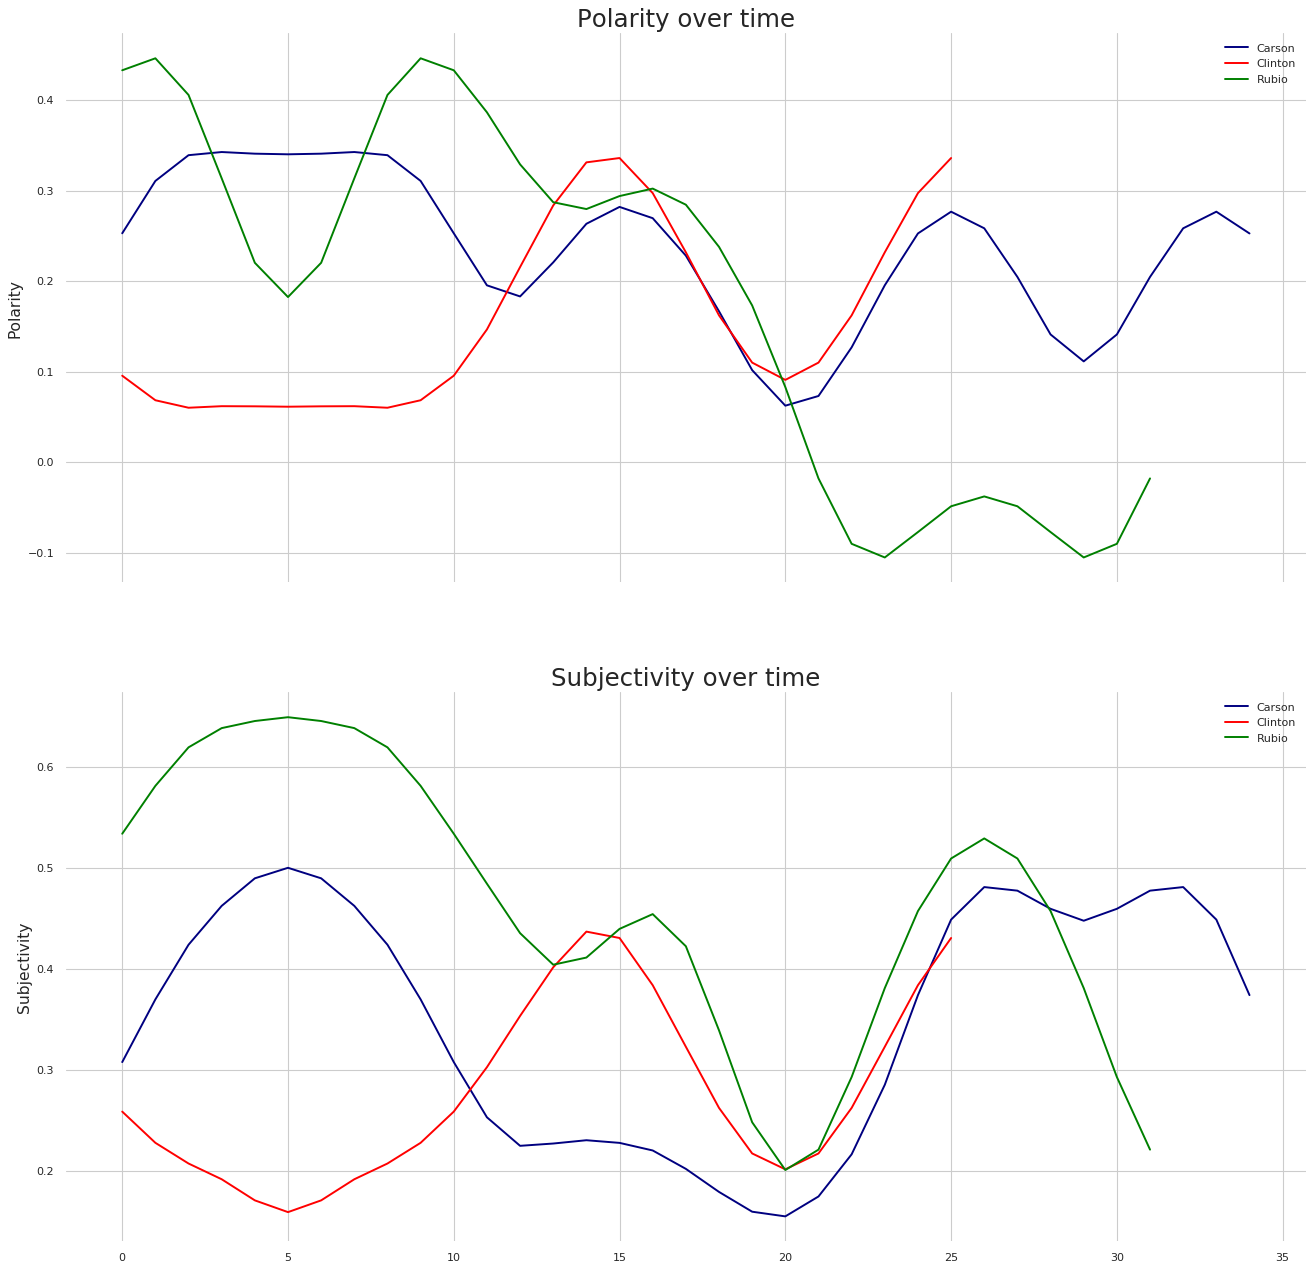

In [44]:
# Plotting polarity
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=80, sharex=True)
sns.lineplot(data=smooth(carson_polarity), label='Carson', color='navy', ax=ax1)
sns.lineplot(data=smooth(clinton_polarity), label='Clinton', color='red', ax=ax1)
sns.lineplot(data=smooth(rubio_polarity), label='Rubio', color='green', ax=ax1)
sns.lineplot(data=smooth(carson_subjectivity), label='Carson', color='navy', ax=ax2)
sns.lineplot(data=smooth(clinton_subjectivity), label='Clinton', color='red', ax=ax2)
sns.lineplot(data=smooth(rubio_subjectivity), label='Rubio', color='green', ax=ax2)
ax1.set_title('Polarity over time', fontsize=22)
ax2.set_title('Subjectivity over time', fontsize=22)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_ylabel('Subjectivity', fontsize=14)
ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()